# Imports

In [139]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

from itertools import combinations, product
from joblib import Parallel, delayed

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

# Loading in the data

In [23]:
prices = pd.read_csv('data/coins.csv', parse_dates=True, index_col=0)
prices.head()

BTC      XRP        BNB      DOGE       ADA       TRX  \
Date                                                                         
2018-01-01  14093.606831  2.31012   8.828099  0.009091  0.747140  0.051654   
2018-01-02  15321.932852  2.45529   9.090393  0.009335  0.807430  0.080893   
2018-01-03  15583.885538  3.12571   9.886323  0.009592  1.075401  0.098107   
2018-01-04  15976.365194  3.22005   9.675758  0.010098  1.179347  0.218139   
2018-01-05  18336.922980  2.93138  16.488523  0.013841  1.077821  0.231673   

                   LTC      LINK          BCH        EOS  ...       UTK  \
Date                                                      ...             
2018-01-01  230.462120  0.751033  2426.970077   7.672278  ...  0.467207   
2018-01-02  255.048185  0.689388  2627.026940   9.504036  ...  0.647065   
2018-01-03  248.042194  0.704623  2630.511811  10.090184  ...  0.896774   
2018-01-04  244.834372  1.036826  2458.894372  11.713284  ...  0.874131   
2018-01-05  254.138525  0.996575  2551.321685   9.673192  ...  0.762206   

                PIVX       SYS       REQ       FUN       VIB      NULS  IDEX  \
Date                                                                           
2018-01-01  10.68950  0.783623  0.867352  0.086325  0.455327  2.267259   NaN   
2018-01-02  11.55500  0.817777  0.809224  0.088933  0.464458  2.510494   NaN   
2018-01-03  10.92360  0.798803  0.795348  0.106564  0.584170  3.696732   NaN   
2018-01-04  10.58120  0.784280  0.826834  0.178514  0.698240  4.788923   NaN   
2018-01-05   9.95117  0.748309  0.761799  0.161191  0.585847  5.659994   NaN   

            MDT  BORG  
Date                   
2018-01-01  NaN   NaN  
2018-01-02  NaN   NaN  
2018-01-03  NaN   NaN  
2018-01-04  NaN   NaN  
2018-01-05  NaN   NaN  

[5 rows x 86 columns]

- Here we have the data $$P^A_t, P^B_t$$ 
    - where $P^x_t$ is the price of stock $x \in \{A,B\}$ at time $t$

- We take $$p_t = log(P_t)$$ 
    - as the log price

In [24]:
wiki_data = pd.read_csv('data/wiki_dv.csv', parse_dates=True, index_col=0)
wiki_data = wiki_data.loc[:pd.Timestamp('2024-08-16')]
wiki_data.head()

BTC  XRP  BNB  DOGE  ADA   TRX  LTC  LINK   BCH   EOS  ...  SYS  \
date                                                               ...        
2018-01-01   23   76  0.0   0.0  0.0  33.0   12   0.0  27.0   5.0  ...  9.0   
2018-01-02   40  144  0.0   0.0  0.0  48.0   22   0.0  23.0  11.0  ...  5.0   
2018-01-03   44  178  0.0   0.0  0.0  51.0   18   0.0  29.0  12.0  ...  9.0   
2018-01-04   65  196  0.0   5.0  0.0  90.0   18   0.0  26.0  11.0  ...  8.0   
2018-01-05   78  176  0.0   4.0  0.0  81.0   20   1.0  15.0  15.0  ...  7.0   

            REQ   FUN   VIB  IDEX  MDT  BORG  STEEM  ZRX  ICX  
date                                                           
2018-01-01  0.0   5.0   5.0   2.0   15   0.0    837  0.0  0.0  
2018-01-02  0.0   3.0   5.0   4.0   22   0.0   1619  0.0  0.0  
2018-01-03  0.0   4.0   3.0  10.0   29   0.0   1708  0.0  0.0  
2018-01-04  0.0  11.0   2.0   3.0   28   0.0   1709  0.0  0.0  
2018-01-05  0.0   1.0  10.0   2.0   20   0.0   1576  0.0  0.0  

[5 rows x 76 columns]

In [25]:
attention = pd.read_csv('data/wiki_daily_pct_change.csv', parse_dates=True, index_col=0)
attention = attention.loc[:pd.Timestamp('2024-08-16')]
attention.head()

BTC       XRP  BNB  DOGE  ADA       TRX       LTC  LINK  \
date                                                                       
2018-01-02  0.739130  0.894737  NaN   NaN  NaN  0.454545  0.833333   NaN   
2018-01-03  0.100000  0.236111  NaN   NaN  NaN  0.062500 -0.181818   NaN   
2018-01-04  0.477273  0.101124  NaN   NaN  NaN  0.764706  0.000000   NaN   
2018-01-05  0.200000 -0.102041  NaN  -0.2  NaN -0.100000  0.111111   NaN   
2018-01-06 -0.435897 -0.500000  NaN  -1.0  NaN -0.469136  0.050000  -1.0   

                 BCH       EOS  ...       SYS  REQ       FUN       VIB  \
date                            ...                                      
2018-01-02 -0.148148  1.200000  ... -0.444444  NaN -0.400000  0.000000   
2018-01-03  0.260870  0.090909  ...  0.800000  NaN  0.333333 -0.400000   
2018-01-04 -0.103448 -0.083333  ... -0.111111  NaN  1.750000 -0.333333   
2018-01-05 -0.423077  0.363636  ... -0.125000  NaN -0.909091  4.000000   
2018-01-06  0.733333 -0.266667  ... -0.428571  NaN  0.000000 -0.400000   

                IDEX       MDT  BORG     STEEM  ZRX  ICX  
date                                                      
2018-01-02  1.000000  0.466667   NaN  0.934289  NaN  NaN  
2018-01-03  1.500000  0.318182   NaN  0.054972  NaN  NaN  
2018-01-04 -0.700000 -0.034483   NaN  0.000585  NaN  NaN  
2018-01-05 -0.333333 -0.285714   NaN -0.077823  NaN  NaN  
2018-01-06 -0.500000  0.000000   NaN -0.109137  NaN  NaN  

[5 rows x 76 columns]

- Here we have the attention data for each stock 

In [26]:
common_idx = prices.index.intersection(attention.index)
prices = prices.loc[common_idx]
attention = attention.loc[common_idx]

we make sure the attention data and price data are on the same index

In [27]:
tot_data_points = len(attention)
non_null_points = attention.notnull().sum()

thresh= 0.90 * tot_data_points

attention = attention.loc[:, non_null_points >= thresh]

- filter out the attention data that doesnt have more than 90% of the data points

In [28]:
prices = prices[attention.columns]
prices.head()

BTC      XRP       TRX         LTC          BCH  \
2018-01-02  15321.932852  2.45529  0.080893  255.048185  2627.026940   
2018-01-03  15583.885538  3.12571  0.098107  248.042194  2630.511811   
2018-01-04  15976.365194  3.22005  0.218139  244.834372  2458.894372   
2018-01-05  18336.922980  2.93138  0.231673  254.138525  2551.321685   
2018-01-06  18343.662493  3.09163  0.179287  289.930033  2674.247838   

                  EOS        ETC          MKR       XLM         XMR  ...  \
2018-01-02   9.504036  35.458893  1117.461121  0.553798  376.534960  ...   
2018-01-03  10.090184  36.998282  1152.971125  0.875563  395.262774  ...   
2018-01-04  11.713284  40.899002  1021.213490  0.755119  415.032997  ...   
2018-01-05   9.673192  32.303204  1125.169367  0.703217  402.510638  ...   
2018-01-06  10.019652  34.724445  1368.353405  0.744453  407.586860  ...   

                   BTG      MLN       MTL         DCR       SNT       SYS  \
2018-01-02  276.993161  151.013   9.44637  110.869422  0.326230  0.817777   
2018-01-03  270.551905  179.530   9.65567  109.774634  0.684918  0.798803   
2018-01-04  278.779874  258.258  11.31960  115.662575  0.564724  0.784280   
2018-01-05  281.431879  229.037   9.21965  117.924697  0.528349  0.748309   
2018-01-06  304.699898  241.914   7.54013  122.030868  0.539078  0.863969   

                 VIB  IDEX  MDT     STEEM  
2018-01-02  0.464458   NaN  NaN  6.885751  
2018-01-03  0.584170   NaN  NaN  8.191466  
2018-01-04  0.698240   NaN  NaN  7.107090  
2018-01-05  0.585847   NaN  NaN  6.203547  
2018-01-06  0.617975   NaN  NaN  7.024439  

[5 rows x 50 columns]

we make prices keep only the coins that we have wiki data on

# Train and Test set

In [29]:
train_end = pd.Timestamp('2019-12-31') # end of training set
train = prices.loc[:train_end]
test = prices.loc[train_end + pd.DateOffset(days=1): ]

# Selecting Pairs (correlation)

In [ ]:
def pairs_selection(data, n=5, threshold=0.9):

    """
    for each coin selects top n correlated coins from absolute correlation matrix
    """
        
    # calculate absolute correlation matrix
    corr = data.corr().abs()

    # set to hold unique pairs and dict to hold top n pairs for each coin 
    pairs = set()
    top_pairs = {}

    # loop through each coin
    for coin in corr.columns:

        # drop self correlations
        series = corr[coin].drop(index=coin)

        # keep correlations above the threshold 
        strong = series[series >= threshold]

        # keep top n 
        top_n = strong.nlargest(n)

        # record for this coin and global set
        top_pairs[coin] = top_n.index.tolist()
        pairs.update((coin, other) for other in top_n.index)

    # sort and return 
    pairs_list = sorted(pairs)
    
    return pairs_list

# Indicators and positions

- We use the OLS formula $$p^A_t = \alpha_t + \beta_t p^B_t + \epsilon_t$$

- Where $$\beta_t = \frac{cov_t(p^A_t, P^B_t)}{var_t(p^A_t)}$$ 
    - where $cov_t(p^A_t, P^B_t)$ is the rolling covariance of $p^A_t, p^B_t$ and $var_t(p^A_t)$ is the rolling variance of stock $p^A_t$
    - $\beta_t$ tells us how many units of coin B to long/short

- We find $\alpha_t$ by $$\alpha_t = \mu_{p^B_t} - \beta_t \mu_{p^A_t}$$
    - where $\mu_{p^A_t}, \mu_{p^B_t}$ are the rolling means of $p^A_t, p^B_t$

- And we take the Z-score as $$z = \frac{\epsilon_t - \mu_t}{\sigma_t}$$
    - where $\mu_t$ is the rolling mean of the spread and $\sigma_t$ is the rolling s.d of the spread 

In [ ]:
def compute_pair_indicators(data, pairs, window=90):

    """
    For each (A, B) pair, compute rolling:
      • beta (cov/var)
      • alpha (mean_B - beta*mean_A)
      • spread (A - (beta*B + alpha))
      • z_score (spread normalised)
    """

    # empty dict to hold indicator data 
    indicators = {}

    # loop through each pair
    for pair in pairs:
        A, B = pair 

        # define the log prices 
        p_A = np.log(data[A].replace(0, np.nan).ffill())
        p_B = np.log(data[B].replace(0, np.nan).ffill())

        # define rolling covariance and variance
        cov_t = p_A.rolling(window, min_periods=1).cov(p_B)
        var_t = p_A.rolling(window, min_periods=1).var()

        # calculate beta and alpha
        beta_t = cov_t / var_t
        alpha_t = p_B.rolling(window, min_periods=1).mean() - beta_t * p_A.rolling(window, min_periods=1).mean()

        # calculate the spread
        spread = p_A - (beta_t * p_B + alpha_t)

        # calculate mean and std of the spread
        mu = spread.rolling(window, min_periods=1).mean()
        sigma = spread.rolling(window, min_periods=1).std()

        # calculate z-score
        z_score = (spread - mu) / sigma
        
        # store the indicators in the dict
        indicators[(pair, 'beta')] = beta_t
        indicators[(pair, 'alpha')] = alpha_t
        indicators[(pair, 'spread')] = spread
        indicators[(pair, 'z_score')] = z_score
    
    # convert the dict to df 
    indicators = pd.DataFrame(indicators)
    return indicators

- Entry
    - We long A and short B when $$z_t < -e$$
    - We short A and long B when $$z_t > e$$
        - for some entry threshold e

- Exit
    - close the position when either $z_t > x$ or $z_t < -x$ 
        - for some exit threshold x

In [32]:
def gen_positions(indics, pairs, dataset, exit=0.5, entry=1.0):

    """
    Build and normalise portfolio positions from z-score indics

    For each pair:
      • z >  1 -> short A, long β·B  
      • z < -1 -> long  A, short β·B  
      • |z| ≤ threshold -> exit

    Positions are forward filled and scaled so that positions sum to 1
    """

    # empty positions table
    positions = pd.DataFrame(index=indics.index, columns=dataset.columns, dtype=float)

    # loop through pairs
    for pair in pairs:
        A, B = pair

        # get z score
        z_score = indics[(pair, 'z_score')]
        # get beta
        beta = indics[(pair, 'beta')]
        
        # build boolean masks 
        mask_long  =   z_score >  entry
        mask_short =   z_score < - entry
        mask_exit  =  z_score.abs() <= exit

        # indics for long and short trades
        # A positions
        positions.loc[mask_long,  A] = -1   # entry: short A when z >  1
        positions.loc[mask_short, A] =  1   # entry: long  A when z < -1
        positions.loc[mask_exit,  A] =  0   # exit:   close A when |z| ≤ threshold

        # B positions
        positions.loc[mask_long,  B] =  beta[mask_long].values   # entry: long  β·B when z >  1
        positions.loc[mask_short, B] = -beta[mask_short].values  # entry: short β·B when z < -1
        positions.loc[mask_exit,  B] =  0                         # exit:   close B when |z| ≤ threshold

    # ffill positions - carry forward open trades until you hit an exit signal
    positions = positions.ffill()
    # normalise all positions to sum to 1 (fully invested)
    positions = positions.divide(positions.abs().sum(axis=1), axis=0).fillna(0)
    return positions

In [ ]:
def att_signals(att):
    raw = np.sign(att)                          # +-1 or 0
    neut = raw.sub(raw.mean(axis=1), axis=0)         # dollar neutral
    return neut.div(neut.abs().sum(axis=1), axis=0).fillna(0) # return fully invested


In [34]:
attention_signals = att_signals(attention)

# Plotting Z score and signals

In [145]:
def plot_pair_signals(indicators, pair, exit, entry=1.0):

    # extract data
    z = indicators[(pair, 'z_score')]
    dates = z.index
    price_A = np.log(prices[pair[0]].loc[dates])
    price_B = np.log(prices[pair[1]].loc[dates])

    # entry/exit signals
    long_idx = z[z > entry]
    short_idx = z[z < -entry]
    exit_idx = z[z.abs() <= exit]

    # figure with secondary y axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Prices on primary y
    fig.add_trace(go.Scatter(x=dates, y=price_A, name=pair[0], line=dict(color='blue')), secondary_y=False)
    fig.add_trace(go.Scatter(x=dates, y=price_B, name=pair[1], line=dict(color='orange')), secondary_y=False)

    # Z-score on secondary y
    fig.add_trace(go.Scatter(x=dates, y=z, name='z-score', line=dict(color='black')), secondary_y=True)

    # threshold lines for secondary y
    fig.add_hline(y=entry, line_dash="dash", line_color="green", yref="y2")
    fig.add_hline(y=-entry, line_dash="dash", line_color="green", yref="y2")
    fig.add_hline(y=exit, line_dash="dot", line_color="red", yref="y2")
    fig.add_hline(y=-exit, line_dash="dot", line_color="red", yref="y2")

    # markers for buy/sell on secondary y 
    fig.add_trace(go.Scatter(x=long_idx.index, y=long_idx.values, mode='markers',
        name='Long', marker_symbol='triangle-up', marker_color='green',
        marker_size=8), secondary_y=True)

    fig.add_trace(go.Scatter(
        x=short_idx.index, y=short_idx.values, mode='markers',
        name='Short', marker_symbol='triangle-down', marker_color='red',
        marker_size=8), secondary_y=True)

    fig.add_trace(go.Scatter(
        x=exit_idx.index, y=exit_idx.values, mode='markers',
        name='Exit', marker_symbol='circle', marker_color='orange',
        marker_size=8), secondary_y=True)

    # layout
    fig.update_layout(
        height=500, width=900,
        title_text=f"{pair[0]}/{pair[1]} Log Prices & Z-Score Signals",
        hovermode="x unified")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Log Price", secondary_y=False)
    fig.update_yaxes(title_text="Z-Score", secondary_y=True)

    fig.show()

# Performance Functions

- simple daily returns $$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

In [35]:
coin_returns = prices.pct_change(fill_method=None)

In [36]:
def turnover(positions):
    
    """
    Calculate the turnover of the portfolio positions (absolute change in positions from one day to the next)
    """
    turnover = positions.diff().abs().sum(axis=1)
    return turnover

- Sharpe Ratio $$SR = \frac{E[r_t]}{\sigma(r_t)} \times N^{1/2}$$
    - where $N$ is the number of trading days (252)

In [37]:
def calc_sharpe_ratio(returns):
    
    """
    Calculate the Sharpe ratio of the portfolio returns
    """
    mean_returns = returns.mean()
    volatility = returns.std()

    if volatility == 0 or np.isnan(volatility):
        return np.nan
    return np.sqrt(252) * (mean_returns / volatility)

In [ ]:
def stats(returns):

    """
    Calculate the mean, volatility, Sharpe ratio and hit rate of the portfolio returns
    """

    stats_df = {}
    stats_df['mean'] = returns.mean()*252
    stats_df['vol'] = returns.std()*np.sqrt(252)
    stats_df['sharpe'] = calc_sharpe_ratio(returns)
    stats_df['hit_rate'] = returns[returns>0].count() / returns.count()

    stats = pd.Series(stats_df)
    return stats

In [141]:
def display_stats(th, s, r, v, to, h, ht, ud, attn):
    
    """
    Display the statistics of the strategy in a DataFrame
    """
    stats = {}
    stats['Annual Return'] = f"{(r * 100):.2f}%"  
    stats['Annual Volatility'] = f"{(v * 100):.2f}%"  
    stats['Sharpe Ratio'] = f"{s:.2f}"
    stats['Annual Turnover'] = f"{(to * 100):.2f}%"   
    stats['Hit Rate'] = f"{(h * 100):.2f}%"  
    stats['Holding Period'] = f"{ht:.1f} days"  

    stats_df = pd.DataFrame(stats, index=[f'e = {th[0]}, x = {th[1]}, upd = {ud}, attn = {attn}']).T   
    return stats_df

# Walk forward backtesting

In [ ]:
def plot_heatmaps(sh, r, h, t, upd):
    """
    Draw a 2x2 grid of heatmaps for:
      • sharpe
      • annual returns (%)
      • hit rate (%)
      • turnover (%)
    """
    fig, axes = plt.subplots(2,2,figsize=(12,10))
    for ax,data,title in zip(axes.flatten(), [sh,r,h,t],
                            ["Sharpe Ratio","Annual Returns (%)","Hit Rate (%)","Turnover (%)"]):
        sns.heatmap(data, annot=True, fmt=".2f", ax=ax)
        ax.set_title(f"{title}, UD {upd}")
    plt.tight_layout()
    plt.show()


In [ ]:
def walk_forward_backtest(data, att, exit, upd_days, att_w, entry=1):

    """
    Run a rolling walk forward backtest, training on 2 years and testing on 1 year,
    then rolling forward by upd_days
    
    """    
    # empty list for results and start and end of data time stamps 
    results = []
    start = pd.Timestamp(data.index[0])
    end_of_data = pd.Timestamp(data.index[-1])

    # run this look until we have a non full year period
    while True:
        end = start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        if end + pd.DateOffset(years=1) > end_of_data:
            break
        
        # define train and test sets 
        train = data.loc[start:end]
        test_start = end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        test = data.loc[test_start:test_end]
        
        # get pairs on training set 
        pairs = pairs_selection(train)

        # get inidicators 
        combined = pd.concat([train, test], axis=0)
        indics = compute_pair_indicators(combined, pairs)
        indics = indics.loc[test.index]

        # get positions 
        positions = pd.DataFrame(0, index=test.index, columns=data.columns, dtype=float)
        p0_all = gen_positions(indics.loc[test.index], pairs, test, exit=exit, entry=entry)

        # get attention signals for the same window
        a_all = att.loc[test.index]

        # blend signals and pair positions
        book = (1 - att_w) * p0_all + att_w * a_all

        # normalise each day so abs(weights) sum to 1
        row_totals = book.abs().sum(axis=1)
        positions = book.div(row_totals, axis=0).fillna(0)
        
        # get gross and net returns 
        simple_rtns = test.pct_change(fill_method=None)
        gross_returns = (positions.shift() * simple_rtns).sum(axis=1)

        turn = turnover(positions)  # turnover 
        tcost = 20  # transaction costs in bpts
        net_returns = gross_returns.subtract(turn * tcost * 1e-4, fill_value=0)

        # stats for this strategy 
        s = stats(net_returns)
        s['turnover'] = turn.mean()
        s['Holding Time'] = (upd_days//2) / s['turnover']
        s['train_start'] = train.index.min()
        s['train_end'] = train.index.max()
        s['test_start']  = test.index.min()
        s['test_end']  = test.index.max()
        results.append(s)

        # roll forward by upd_days days 
        start = start + pd.DateOffset(days=upd_days)
    
    return pd.DataFrame(results)


=== upd_days = 90 ===


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   49.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   49.3s finished



--- attention weight = 0.05 ---


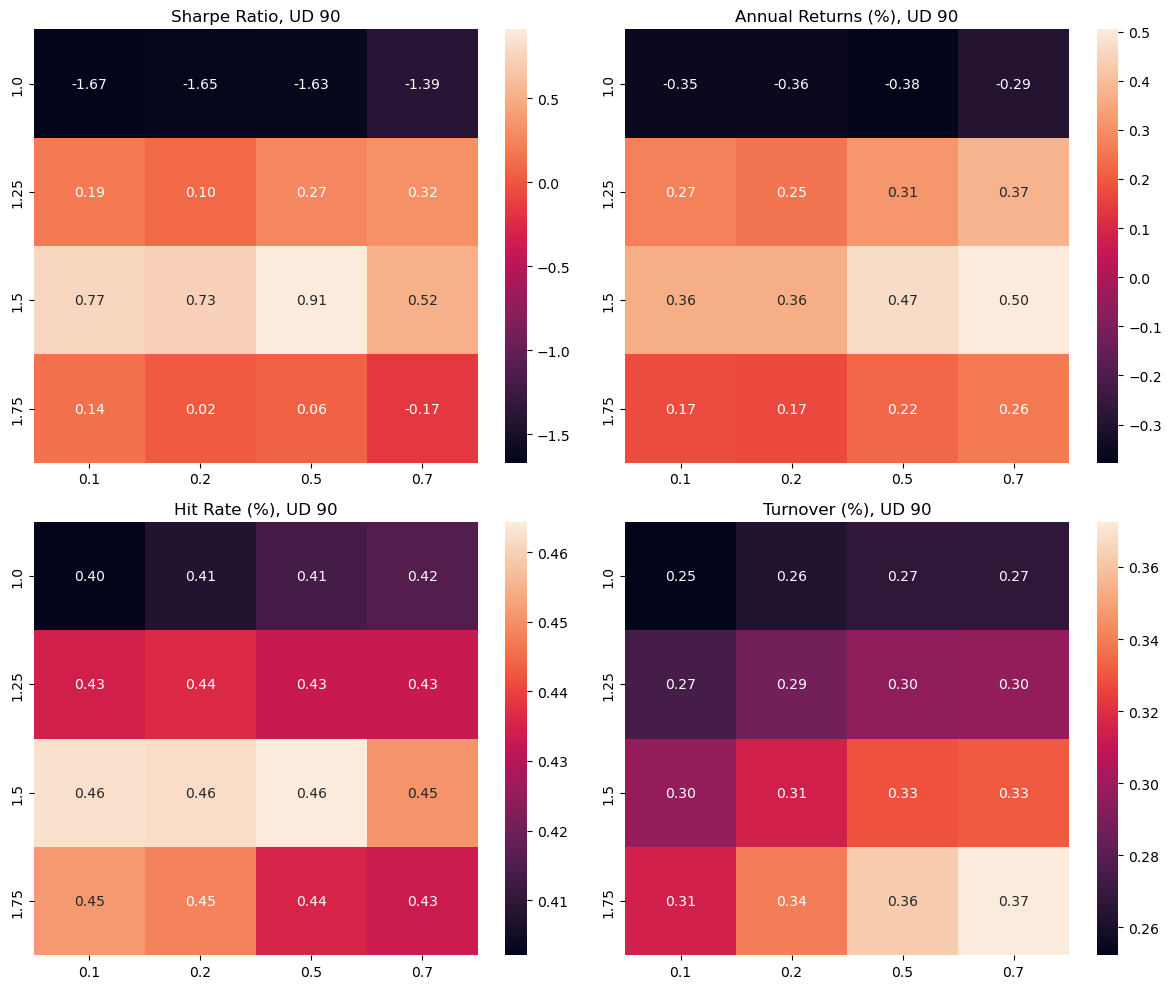


--- attention weight = 0.1 ---


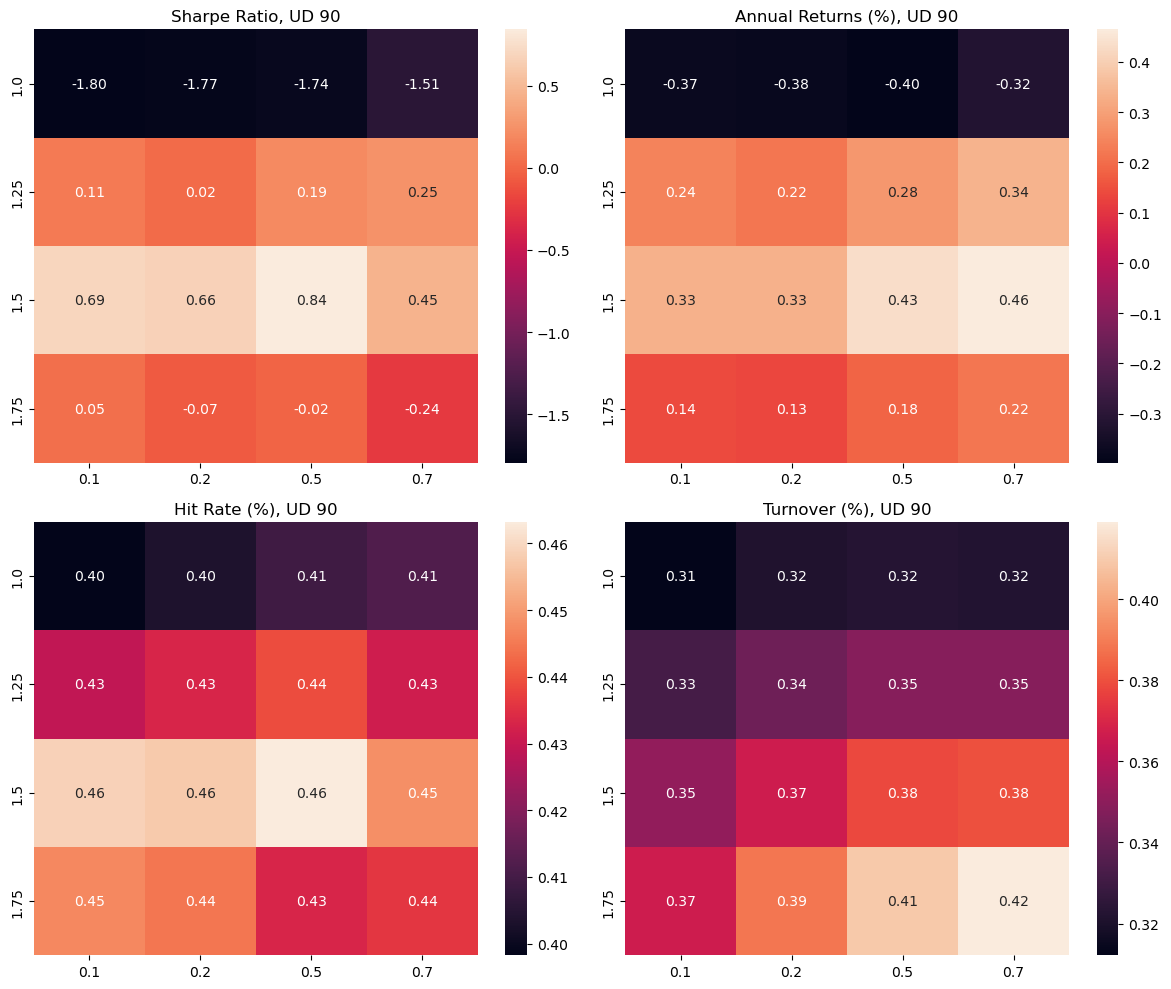


--- attention weight = 0.2 ---


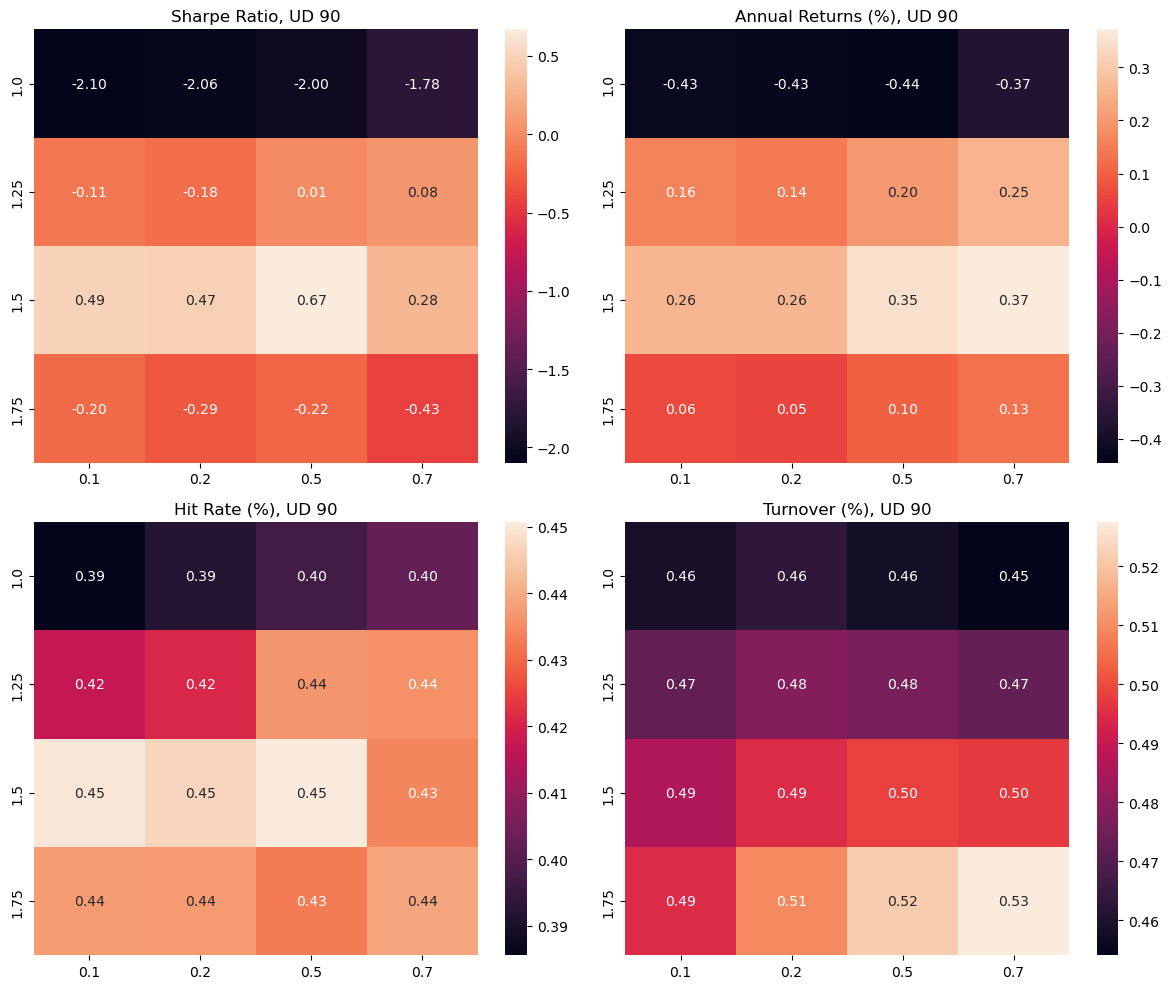


--- attention weight = 0.3 ---


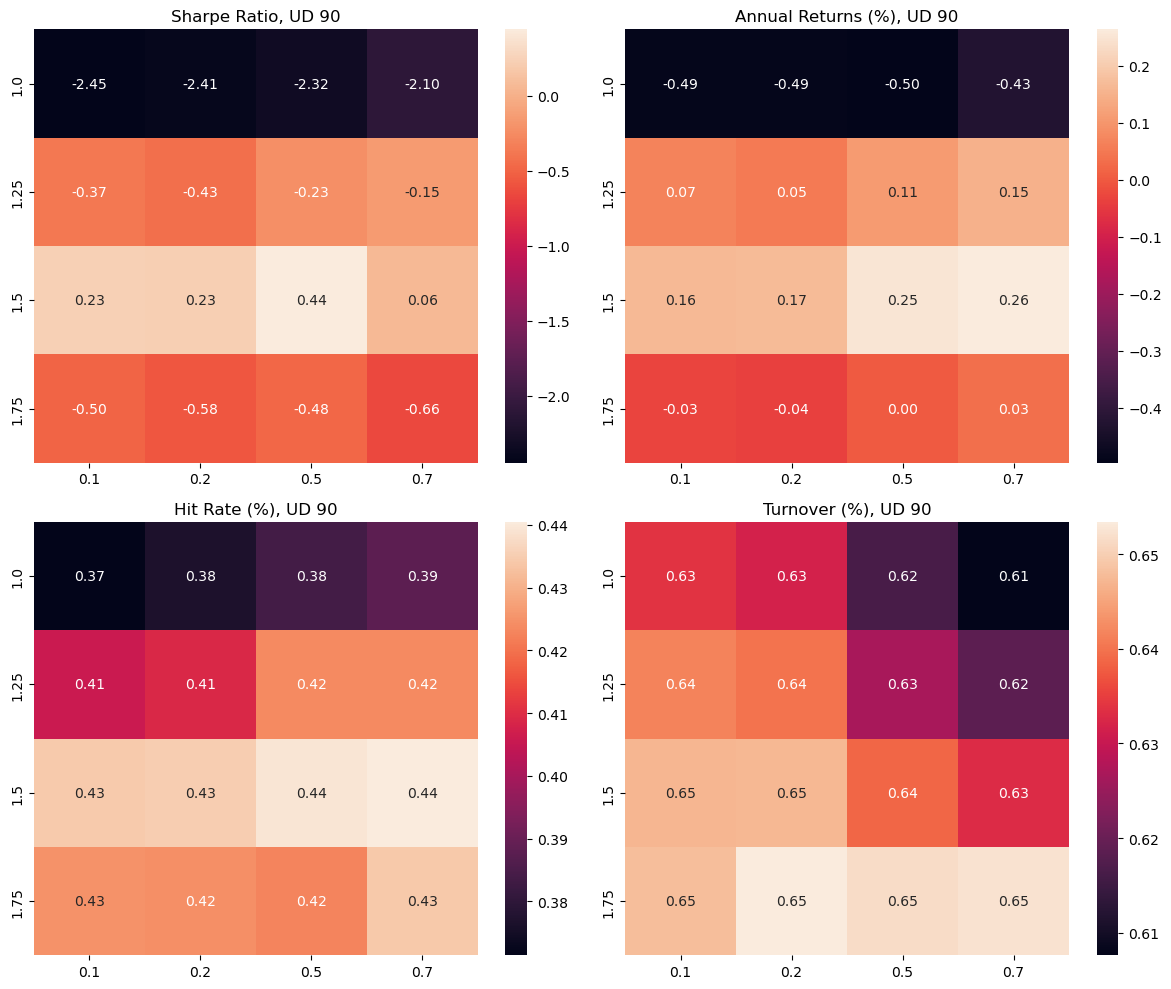


=== upd_days = 180 ===


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   23.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   23.1s finished



--- attention weight = 0.05 ---


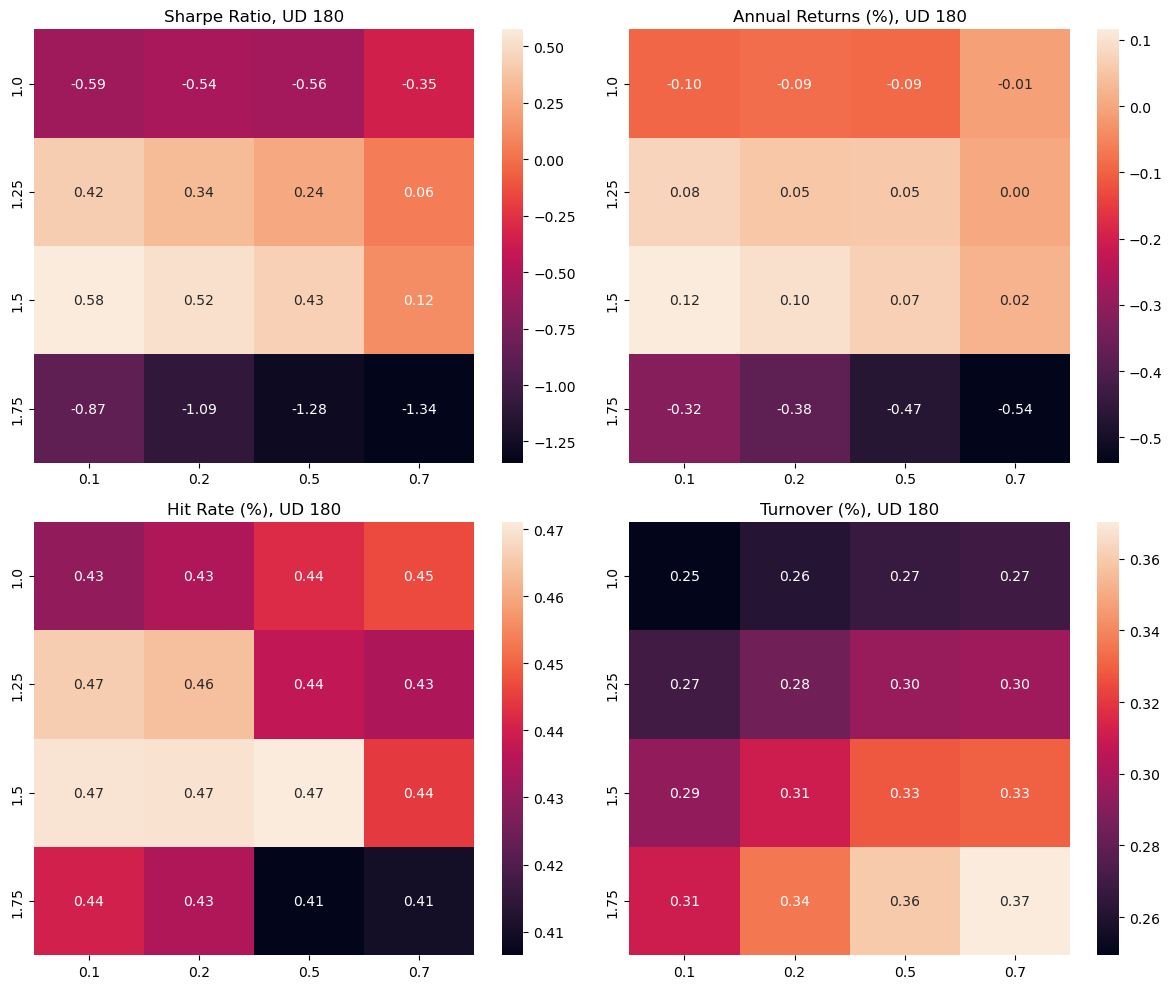


--- attention weight = 0.1 ---


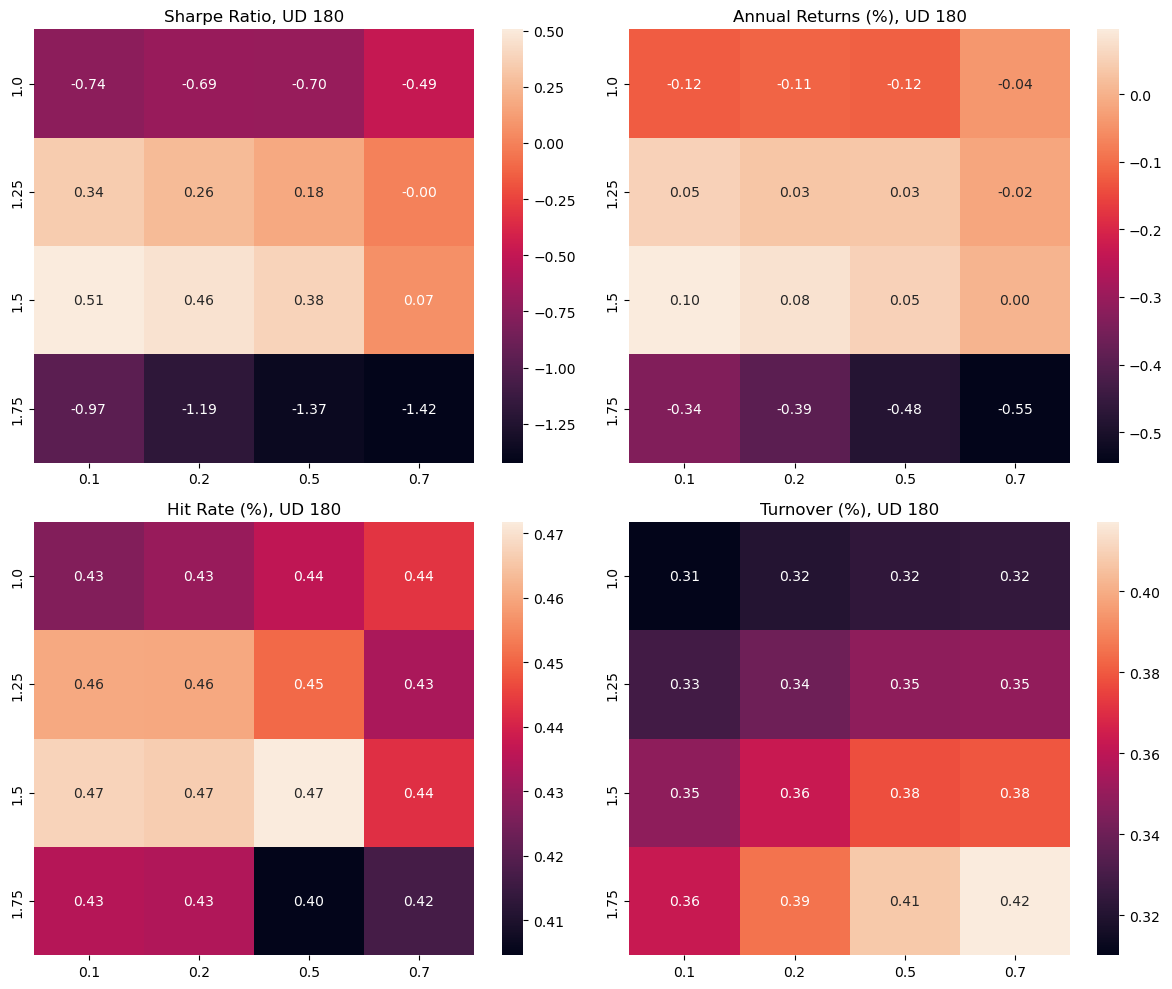


--- attention weight = 0.2 ---


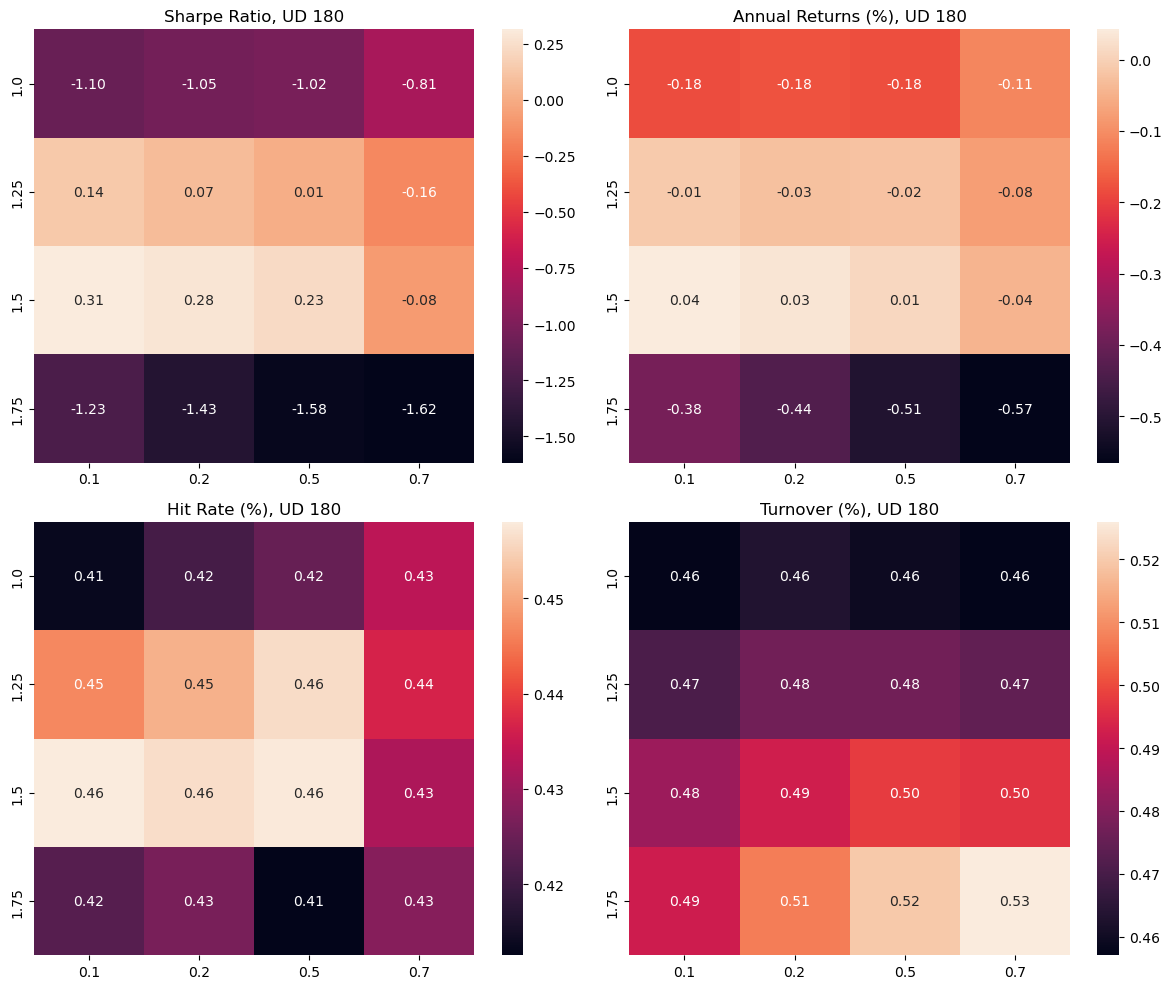


--- attention weight = 0.3 ---


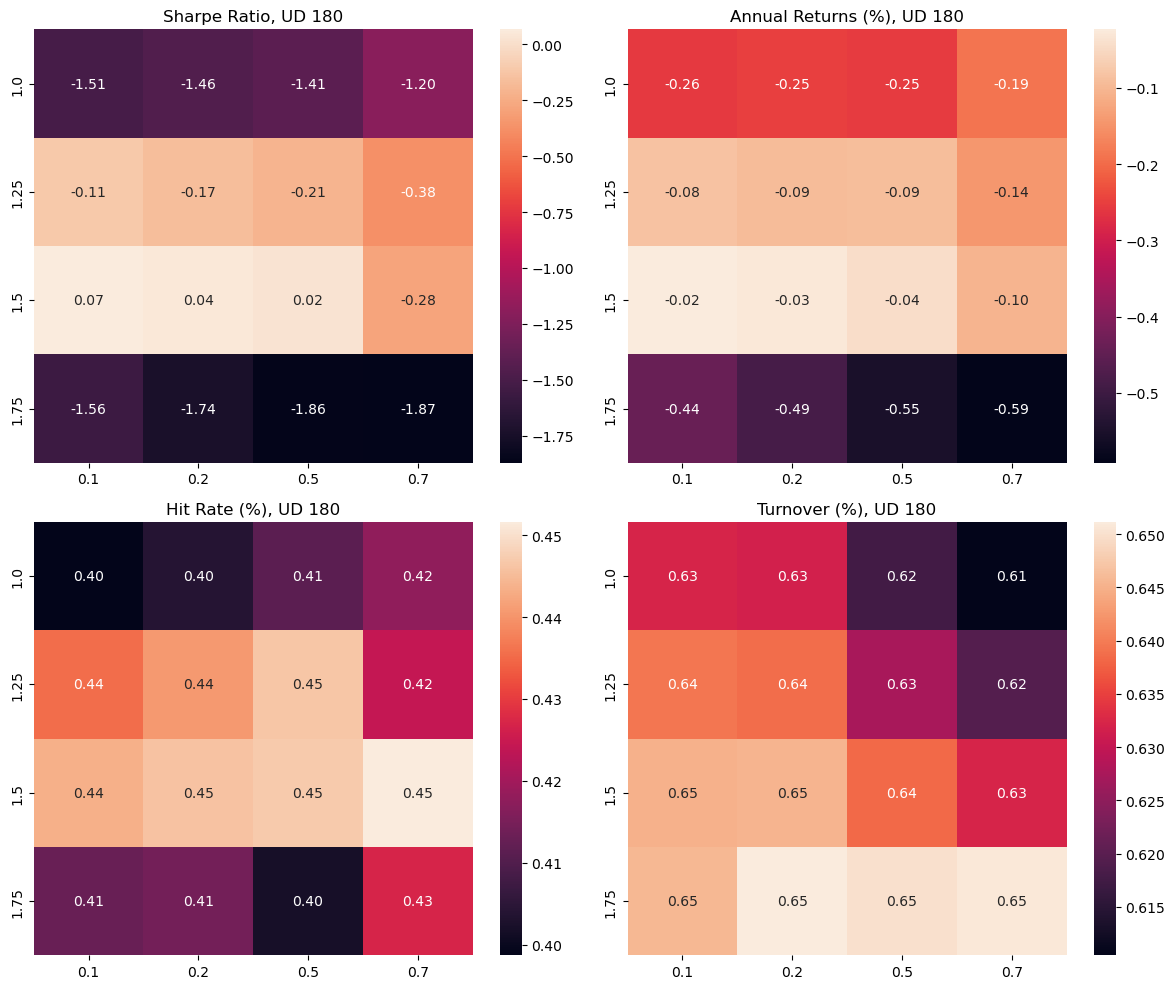

In [ ]:
exit_grid    = [0.1, 0.2, 0.5, 0.7]
entry_grid   = [1.0, 1.25, 1.5, 1.75]
attn_weights = [0.05, 0.1, 0.2, 0.3]
update_days  = [90, 180]


for upd in update_days:
    print(f"\n=== upd_days = {upd} ===")

    # store a heatmap for each attention weight
    grids = {
      att_w: {
        "sharpe":  pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float),
        "returns": pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float),
        "hit":     pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float),
        "turn":    pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float),
      }
      for att_w in attn_weights
    }

    # build all (attn_w, entry, exit) tasks
    tasks = list(product(attn_weights, entry_grid, exit_grid))

    # run them in parallel
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(lambda a, ent, ex: (a, ent, ex, walk_forward_backtest(
                prices,
                attention_signals,
                exit=ex,
                upd_days=upd,
                att_w=a,
                entry=ent)))(a, ent, ex)
        for a, ent, ex in tasks
    )

    # collect into the right grid for each attention weight
    for a, ent, ex, df in results:
        g = grids[a]
        g["sharpe"].loc[ent, ex] = df["sharpe"].mean()
        g["returns"].loc[ent, ex] = df["mean"].mean()
        g["hit"].loc[ent, ex] = df["hit_rate"].mean()
        g["turn"].loc[ent, ex] = df["turnover"].mean()

    # plot heatmaps per attention weight:
    for a in attn_weights:
        print(f"\n--- attention weight = {a} ---")
        plot_heatmaps(grids[a]["sharpe"], grids[a]["returns"], grids[a]["hit"], grids[a]["turn"], upd)

# Optimal Strategy

In [ ]:
best_entry = 1
best_exit  = 0.2
best_attn  = 0.05
tcost      = 20*1e-4 # decimal transaction cost

In [ ]:
# define update days

upd_freq   = "6MS"
update_days = pd.date_range(start=test.index.min(),end=test.index.max(),freq=upd_freq)
update_days

DatetimeIndex(['2020-01-01', '2020-07-01', '2021-01-01', '2021-07-01',
               '2022-01-01', '2022-07-01', '2023-01-01', '2023-07-01',
               '2024-01-01', '2024-07-01'],
              dtype='datetime64[ns]', freq='6MS')

In [ ]:
all_net    = [] # each windows net p&l
pos_slices = [] # each windows positions

for start in update_days:
    # define historical and future data
    train_end = start - pd.DateOffset(days=1)
    historic = prices.loc[start - pd.DateOffset(years=2):train_end]
    future = prices.loc[start: min(start+pd.DateOffset(months=6)-pd.DateOffset(days=3), test.index.max())]

    # get pairs and indicators
    pairs = pairs_selection(historic)
    comb = pd.concat([historic,future])
    indicators = compute_pair_indicators(comb,pairs).loc[future.index]

    # get positions
    p0 = gen_positions(indicators,pairs,future,exit=best_exit,entry=best_entry)

    # attention to match future data index
    a0 = attention_signals.reindex(future.index).fillna(0)

    # raw mix of attn and positions
    book = (1-best_attn)*p0 + best_attn*a0

    # whole positions is book normalised
    pos = book.div(book.abs().sum(axis=1),axis=0).fillna(0)

    simple = future.pct_change()    # simple daily return

    # gross and net costs
    gross_returns = (pos.shift()*simple).sum(axis=1)
    cost = turnover(pos)*tcost
    net_returns  = gross_returns - cost

    # adding this windows data in their respective lists
    all_net.append(net_returns)
    pos_slices.append(pos)

# stitch together
all_net = pd.concat(all_net).sort_index().loc[~pd.concat(all_net).index.duplicated()]

full_pos = pd.concat(pos_slices)
full_pos = (full_pos[~full_pos.index.duplicated(keep='first')].reindex(test.index).ffill())

In [ ]:
# getting statistics for the strategy 
s = stats(all_net)
mean_to = turnover(full_pos).mean()
hold_days = 2/mean_to

e = 1, x = 0.2, upd = 6MS, attn = 0.05
Annual Return                                     18.97%
Annual Volatility                                 30.76%
Sharpe Ratio                                        0.62
Annual Turnover                                   26.30%
Hit Rate                                          50.72%
Holding Period                                  7.6 days

In [ ]:
# displaying stats 
display_stats((best_entry,best_exit), s['sharpe'], s['mean'], s['vol'], mean_to, s['hit_rate'] ,hold_days, upd_freq, best_attn)

# Plotting equity curve

In [144]:
cum_strat = (1+all_net).cumprod()-1

# popular coins to buy and hold 
btc_bh = coin_returns['BTC'].loc[test.index].cumsum()
xrp_bh = coin_returns['XRP'].loc[test.index].cumsum()

In [140]:
df_cum = pd.DataFrame({
    "Pairs Strategy": cum_strat,
    "BTC B/H": btc_bh,
    "XRP B/H": xrp_bh})

df_plot = (df_cum.reset_index().rename(columns={"index": "Date"}).melt(
         id_vars="Date",
         var_name="Strategy",
         value_name="Cumulative Return"))

fig = px.line(df_plot, x="Date", y="Cumulative Return", color="Strategy",
    title=f"Equity Curves (entry={best_entry}, exit={best_exit}, {upd_freq} updates, {best_attn} attn weight)",
    labels={"Date":"Date", "Cumulative Return":"Cumulative Return"})

fig.update_layout(hovermode="x unified")
fig.show()